Загрузка библиотек

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

Импорт файла с данными для сравнения:

In [51]:
exp = pd.read_csv('EngineSem.ind', encoding='latin-1', header=None, skiprows = 19, delimiter='\s+')
exp.columns = ['Fi', 'Pc', 'Tc', 'Vc', 'Alf_w', 'P_1ring', 'G_bb', 'P_pist', 'x']
exp = exp[['Fi', 'Pc', 'Tc', 'x']]
exp['Pc'] = exp['Pc']*10**5
exp.head(5)

,Fi,Pc,Tc,x
0,180.0,453000.0,369.4,2.000000e+25
1,181.0,453000.0,369.6,2.000000e+25
2,182.0,454000.0,369.8,2.000000e+25
3,183.0,455000.0,369.9,2.000000e+25
4,184.0,455000.0,370.2,2.000000e+25


# Исходные данные по двигателю

### Геометрические параметры двигателя

In [52]:
D=0.102          # диаметр цилиндра, м
S=0.122          # ход поршня, м
n_mex=0.82956    # механический КПД
n=2400           # частота вращения, об/мин
icyl=6           # кол-во цилиндров
eps=15           # степень сжатия
lamb=0.264       # R/L
qc  = 7.05e-05  # Цикловая подача
Hu = 42.5*10**6

### Прочие константы

In [53]:
Rm=8.314          # Универсальная газовая постоянная
dFi=np.pi/180     # Приращение угла поворота КВ
N=900             # Статическое количество элементов в массивах

# Функции

### Объем КС как функция угла поворота коленчатого вала:
$$ V(\phi) = V_c + V_h -\frac{\pi D^2} 4 \frac{S} 2 ((1 - cos (\phi))-\frac{\lambda} 4 (1 -cos(2\phi)))$$

In [54]:
def Vol(deg):
    Ap = np.pi * D ** 2 / 4
    Vh = Ap * S
    Vc = Vh / (eps - 1)
    V = Vc + Vh - Ap * S / 2 * (1 - np.cos(np.deg2rad(deg)) - lamb / 4 * (1 - np.cos(2*np.deg2rad(deg))))
    return (V)

### Термодинамическая работа
$$ \frac{dL} {d\phi} = -p\frac{dV}{d\phi} $$

In [55]:
def dL(P, Fi):
    dl = -P * (Vol(Fi+1) - Vol(Fi))/dFi
    return dl

### Теплообмен с окружающими деталями КС:
$$ \frac{dQ_w} {d\phi} = \qquad \sum_{i=1}^3 \alpha_w(T-T_w^i)F_i \frac{dt}{d\omega} $$
Площадь крышки цилиндра:
$$ F_k = \frac{\pi D^2} 4 $$
Площадь поршня:
$$ F_p = 1.4 F_k $$
Площадь гильзы:
$$ F_{cyl}(\phi) = {\pi D}(\delta + S_p(\phi)) $$
Коэффициент теплоотдачи по формуле Г. Эйхельберга:
$$ \alpha_w(\phi) = 77.9 \cdot 10^{-4} C_m^{\frac 1 3} \sqrt{PT} $$

In [56]:
def dQw(P, T, Fi):
    delta = 0.005
    T_h = 473
    T_cyl = 420
    T_p = 521
    Cm = S * n / 30
    Fpist = np.pi*D**2/4
    Vh = Fpist * S
    Vc = Vh / (eps - 1)
    Fcyl = ((Vol(Fi) - Vc) / Fpist + delta) * np.pi * D
    alfa_w =77.9 * 10 ** (-4) * Cm ** (1 / 3) * np.sqrt(P * T)
    dQh = alfa_w * (T - T_h) * 1.4 * Fpist
    dQcyl = alfa_w * (T - T_cyl) * Fcyl
    dQp = alfa_w * (T - T_p) * Fpist
    dqw = -(dQp + dQcyl + dQh) / (np.pi * n / 30)
    return dqw

# Основная программа

### Получение данных о характеристике тепловыделения

Пусть пока теплоемкость будет 23

In [57]:
cv = 25

Определим слагаемые для Первого Закона Термодинамики


$$ \dfrac{dQ_{сг}} {d\phi} = \dfrac{dU} {d\phi} - \dfrac{dL} {d\phi} - \dfrac{dQ_w} {d\phi} $$
$$ \dfrac{dU} {d\phi} = C_v\dfrac{d(MT)} {d\phi}  \quad | pV = MRT | \quad = \frac{C_v}{R_m}\dfrac{d(pV)} {d\phi}$$ 
$$ \frac{dL} {d\phi} = -p\frac{dV}{d\phi} $$
$$ \frac{dQ_w} {d\phi} = \qquad \sum_{i=1}^3 \alpha_w(T-T_w^i)F_i \frac{dt}{d\omega} $$
Тогда формула для тепла выделившегося при сгорании примет вид:
$$ \dfrac{dQ_{сг}} {d\phi} = (\frac{C_v}{R_m}+1)p\frac{dV}{d\phi} + \frac{C_v}{R_m}V\frac{dp}{d\phi} -\dfrac{dQ_w} {d\phi}  $$

In [58]:
dQc = []
for i in range (720):
    dQ1=(cv/Rm+1)*exp['Pc'][i]*(Vol(i+1)-Vol(i))/dFi;
    dQ2=cv/Rm*Vol(i)*(exp['Pc'][i+1]-exp['Pc'][i])/dFi;
    dQ3=dQw(exp['Pc'][i],exp['Tc'][i],i);
    dQc.append(dQ1+dQ2-dQ3)
dQc =np.array(dQc)

График тепла   $ \dfrac{dQ_{сг}} {d\phi} $ от угла поворота КВ

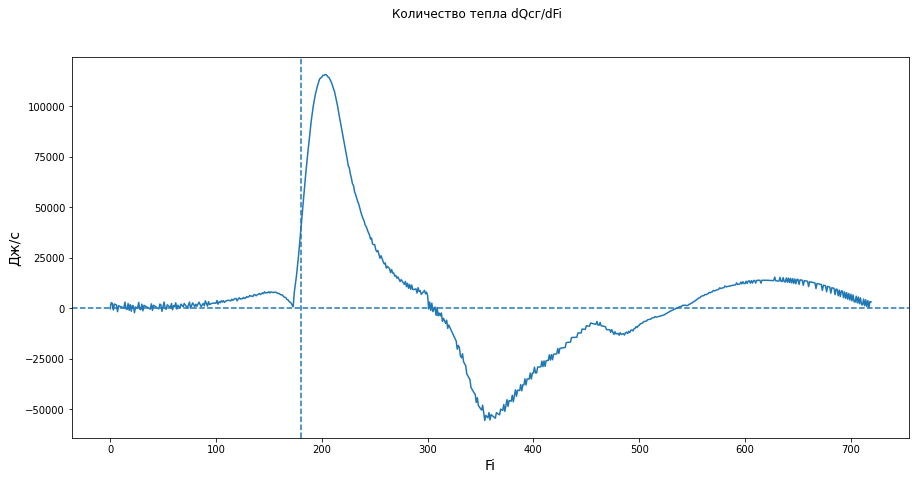

In [74]:
fig, ax = plt.subplots(figsize=(15,7))
plt.suptitle('Количество тепла dQсг/dFi')
plt.plot(dQc)
plt.ylabel('Дж/c', fontsize=14)
plt.xlabel('Fi', fontsize=14)
plt.axhline(0, linestyle="--", label = 'ВМТ')
plt.axvline(180, linestyle="--", label = 'ВМТ')
plt.show()

Скорость тепловыделения:
$$ \dfrac{dQ_{сг}} {d\phi} = Hu\dfrac{dx} {d\phi}q_c $$

График тепла   $ \dfrac{dx} {d\phi} $ от угла поворота КВ

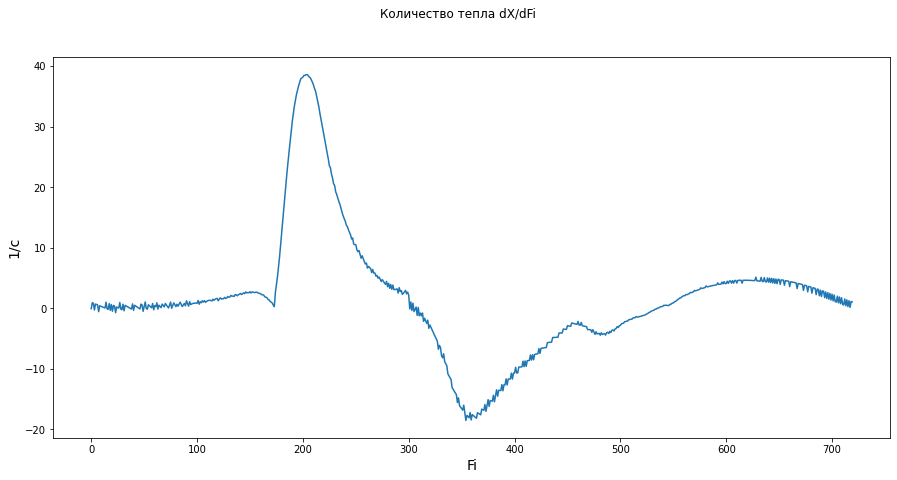

In [60]:
fig, ax = plt.subplots(figsize=(15,7))
plt.suptitle('Количество тепла dX/dFi')
plt.plot(dQc/Hu/qc)
plt.ylabel('1/c', fontsize=14)
plt.xlabel('Fi', fontsize=14)
plt.show()

Необходимо на интервале где происходит сгорание - записать dXdFi в отдельную переменную

In [61]:
dXdFi = dQc[179:270]/Hu/qc

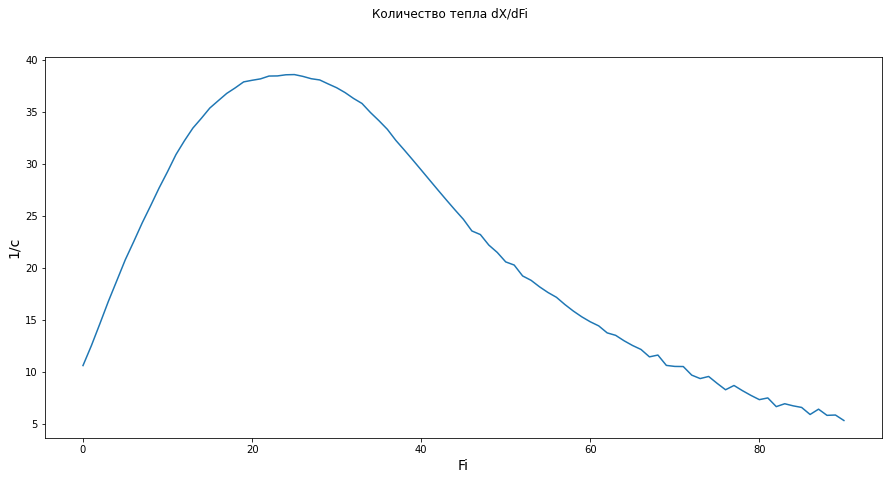

In [62]:
fig, ax = plt.subplots(figsize=(15,7))
plt.suptitle('Количество тепла dX/dFi')
plt.plot(dXdFi)
plt.ylabel('1/c', fontsize=14)
plt.xlabel('Fi', fontsize=14)
plt.show()

### Использование формулы Вибе для моделирования сгорания

Для дизельного двигателя можно записать с следующим виде:
$$ \dfrac{dx_{диз}} {d\phi} =  \dfrac{dx_{об}} {d\phi} + \dfrac{dx_{диф}} {d\phi} $$
Для объемного сгорания:
$$ \dfrac{dx_{об}} {d\phi} =\chi_t [\frac{m_t}{\phi_{сг}}][\frac{\phi}{\phi_{сг}}]exp(-\frac{m_t}{m_t+1}[\frac{\phi}{\phi_{сг}}]^{m_t+1})$$
Для диффузионного сгорания:
$$ \dfrac{dx_{диф}} {d\phi} = (1-\chi_t) C [\frac{m_v+1}{\phi_{z}}][\frac{\phi}{\phi_{z}}]exp(-C[\frac{\phi}{\phi_{z}}]^{m_v+1})$$
$ \chi_t $ - доля топлива сгоревшего по кинетическому механизму;

$ m_t $ - показатель кинетического сгорания;

$ \phi_{сг} $ - угол максимального скорости кинетического сгорания;

$ m_v $ - показатель объемного сгорания;

$ С = -ln[1-\Delta x] $ 

$\Delta x $ - доля сгоревшего топлива за весь процесс (обычно принимается ~0.99);

$ \phi_{z} $ - полная продолжительность процесса сгорания.

Необходимо подобрать константы (кроме тех, что можно "взять с графика")

In [63]:
ksi=0.05
dx=0.99
mt=2
mv=0.85
Fiz=3
Fic=55
C=-np.log(1-dx)

Записать функцию для определения скорости тепловыделения

In [64]:
def hrr (Fi, ksi, mt, mv, Fic):
    KiN = (mt/Fiz)*(Fi/Fiz)**mt*np.exp(-mt/(mt+1)*(Fi/Fiz)**(mt+1))
    Dif = C*((mv+1)/Fic)*(Fi/Fic)**mv*np.exp(-C*(Fi/Fic)**(mv+1))
    return (ksi*KiN+(1-ksi)*Dif)

In [65]:
Fi = np.linspace(0, 90, 90)
dXdFicalc = hrr (Fi, ksi, mt, mv, Fic)

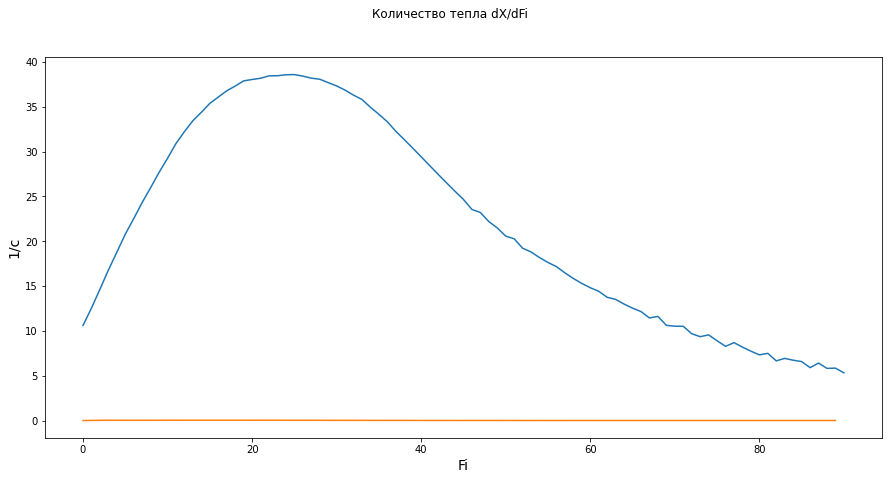

In [66]:
fig, ax = plt.subplots(figsize=(15,7))
plt.suptitle('Количество тепла dX/dFi')
plt.plot(dXdFi)
plt.plot(dXdFicalc)
plt.ylabel('1/c', fontsize=14)
plt.xlabel('Fi', fontsize=14)
plt.show()

Похоже на то, что это не является оптимальным решением

## Подбор коэффициентов в формуле Вибе 

Вектор начальных значений

In [67]:
X0 = [ksi, mt, mv, Fic]
X0

[0.05, 2, 0.85, 55]

Определение функции цели

In [68]:
def target(X):
    Fi = np.linspace(0, 91, 91)
    ksi =X[0] 
    mt = X[1]
    mv = X[2]
    Fic = X[3]
    tag = hrr (Fi, ksi, mt, mv, Fic) - dXdFi
    return np.linalg.norm(tag)

Минимизация величины целевой функции

In [69]:
res = minimize(target, X0, method='SLSQP')
res

C:\Users\ans\AppData\Local\Temp\ipykernel_5884\3823831360.py:2: RuntimeWarning: divide by zero encountered in power
  KiN = (mt/Fiz)*(Fi/Fiz)**mt*np.exp(-mt/(mt+1)*(Fi/Fiz)**(mt+1))
C:\Users\ans\AppData\Local\Temp\ipykernel_5884\3823831360.py:2: RuntimeWarning: invalid value encountered in multiply
  KiN = (mt/Fiz)*(Fi/Fiz)**mt*np.exp(-mt/(mt+1)*(Fi/Fiz)**(mt+1))
C:\Users\ans\AppData\Local\Temp\ipykernel_5884\3823831360.py:3: RuntimeWarning: divide by zero encountered in power
  Dif = C*((mv+1)/Fic)*(Fi/Fic)**mv*np.exp(-C*(Fi/Fic)**(mv+1))
C:\Users\ans\AppData\Local\Temp\ipykernel_5884\3823831360.py:3: RuntimeWarning: invalid value encountered in multiply
  Dif = C*((mv+1)/Fic)*(Fi/Fic)**mv*np.exp(-C*(Fi/Fic)**(mv+1))
C:\Users\ans\AppData\Local\Temp\ipykernel_5884\3823831360.py:2: RuntimeWarning: overflow encountered in power
  KiN = (mt/Fiz)*(Fi/Fiz)**mt*np.exp(-mt/(mt+1)*(Fi/Fiz)**(mt+1))
W:\_PracticumYandex\practicum\practicum_env\lib\site-packages\scipy\optimize\_numdiff.py:576: Ru

 message: Iteration limit reached
 success: False
  status: 9
     fun: nan
       x: [       nan        nan        nan        nan]
     nit: 100
     jac: [       nan        nan        nan        nan]
    nfev: 1178
    njev: 100

Итоговые значения коэффициентов

In [70]:
ksi =res.x[0] 
mt = res.x[1] 
mv = res.x[2] 
Fic = res.x[3] 
print ('ksi = ', ksi)
print ('mt = ', mt)
print ('mv = ', mv)
print ('Fic = ', Fic)

ksi =  nan
mt =  nan
mv =  nan
Fic =  nan


In [71]:
Fi = np.linspace(0, 90, 90)
dXdFicalc_opt = hrr (Fi, ksi, mt, mv, Fic)

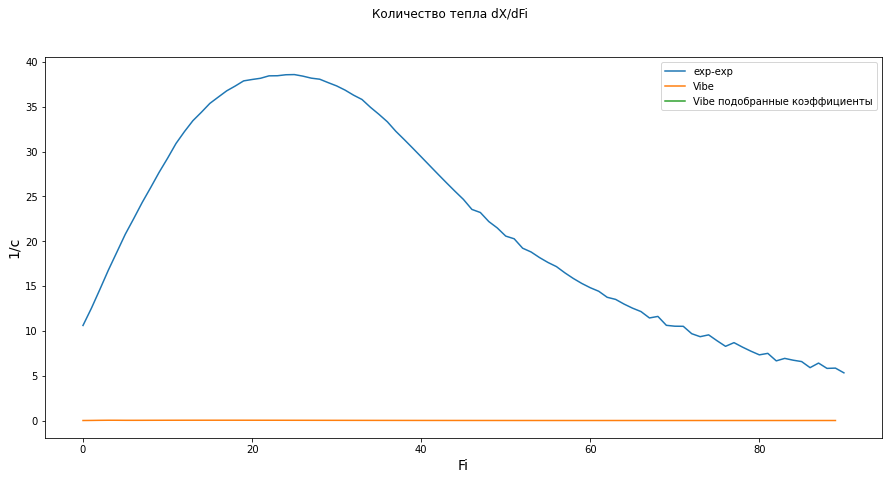

In [72]:
fig, ax = plt.subplots(figsize=(15,7))
plt.suptitle('Количество тепла dX/dFi')
plt.plot(dXdFi, label = 'exp-exp')
plt.plot(dXdFicalc, label = 'Vibe')
plt.plot(dXdFicalc_opt, label =  'Vibe подобранные коэффициенты')
plt.ylabel('1/c', fontsize=14)
plt.xlabel('Fi', fontsize=14)
plt.legend()
plt.show()